# Commodity Price Forecasting

This project aims to forecast prices of key agricultural commodities — **Carne Vacuna, Soja y Trigo** — using various time series modeling approaches. It compares classical, statistical, machine learning, and deep learning models to determine the most accurate one.

## Source
The data comes from the [World Bank Commodity Price Data (The Pink Sheet)](https://www.bcsf.com.ar/ces/base-datos/preview/6/precios-internacionales-de-los-commodities).

## Coverage
Monthly prices in nominal US dollars, covering the period from **January 2010** to **May 2025**.

## Currency
All price series are reported in **nominal US dollars (USD)**.

## Variables Used

| Product  | Unit                         |
|----------|------------------------------|
| Soybeans | US Dollars per Metric Ton     |
| Wheat    | US Dollars per Metric Ton     |
| Meat     | US Dollars per Kilogram       |


## Usage
This dataset can be used for time series analysis, forecasting, and commodity price trend studies.

# Table of Contents

- [1. Introduction](#1-introduction)
- [2. Load and Visualizations](#2-carga-y-visualización-de-las-series)
- [3. Models and Evaluation](#3-modelado-y-evaluacion)
  - [3.1 SARIMAX model](#31-sarimax)
  - [3.2 XGBoost model](#32-xgboost)
  - [3.3 LSTM model](#33-lstm)
- [4. Final Model Comparison and Winner Selection](#4-comparación-final-de-modelos-y-selección-del-ganador)
- [5. Final Conclusions](#5-final-conlusions)
- [6. Forecast using the optimal model](#6-forecasting-with-the-best-model)

## 1. Introduction

This analysis aims to forecast prices of agricultural commodities (trigo, carne y soja) by applying and comparing various time series models, including classical methods, neural networks and statistical models.

## 2. Data Loading and Quality Checks
Historical monthly prices were loaded from an CSV file. The first rows of the dataset were inspected to verify proper loading.  
No additional data cleaning was required as the columns were found to be in good condition and complete.

In [57]:
import pandas as pd
import sys
sys.path.insert(0, './src/')
import importlib
import eda
import read_data
import predict
importlib.reload(read_data)
importlib.reload(eda)
importlib.reload(predict)
from read_data import load_dataset, load_commodity
from eda import plot_time_series_resamples
from eda import check_series_validity



In [20]:
df = load_dataset()
df.head()

,Carne Vacuna,Trigo,Soja,Energy,Maiz,Oro,Metal Index
Date,,,,,,,
2010-01-01,3.02,201.19,435.88,98.50,167.31,1117.96,90.86
2010-02-01,3.21,194.00,411.86,95.60,161.80,1095.41,87.59
2010-03-01,3.40,191.08,409.36,99.58,159.05,1113.34,90.05
2010-04-01,3.66,192.87,402.60,104.85,157.08,1148.69,93.42
2010-05-01,3.58,181.61,402.87,95.68,163.38,1205.43,97.19


In [21]:
df_carne = load_commodity('Carne Vacuna')
df_trigo = load_commodity('Trigo')
df_soja = load_commodity('Soja')

### Check Series Validity 

In [180]:
check_series_validity(df_carne)

(True, [])

In [181]:
check_series_validity(df_trigo)

(True, [])

In [182]:
check_series_validity(df_soja)

(True, [])

### Visualizations

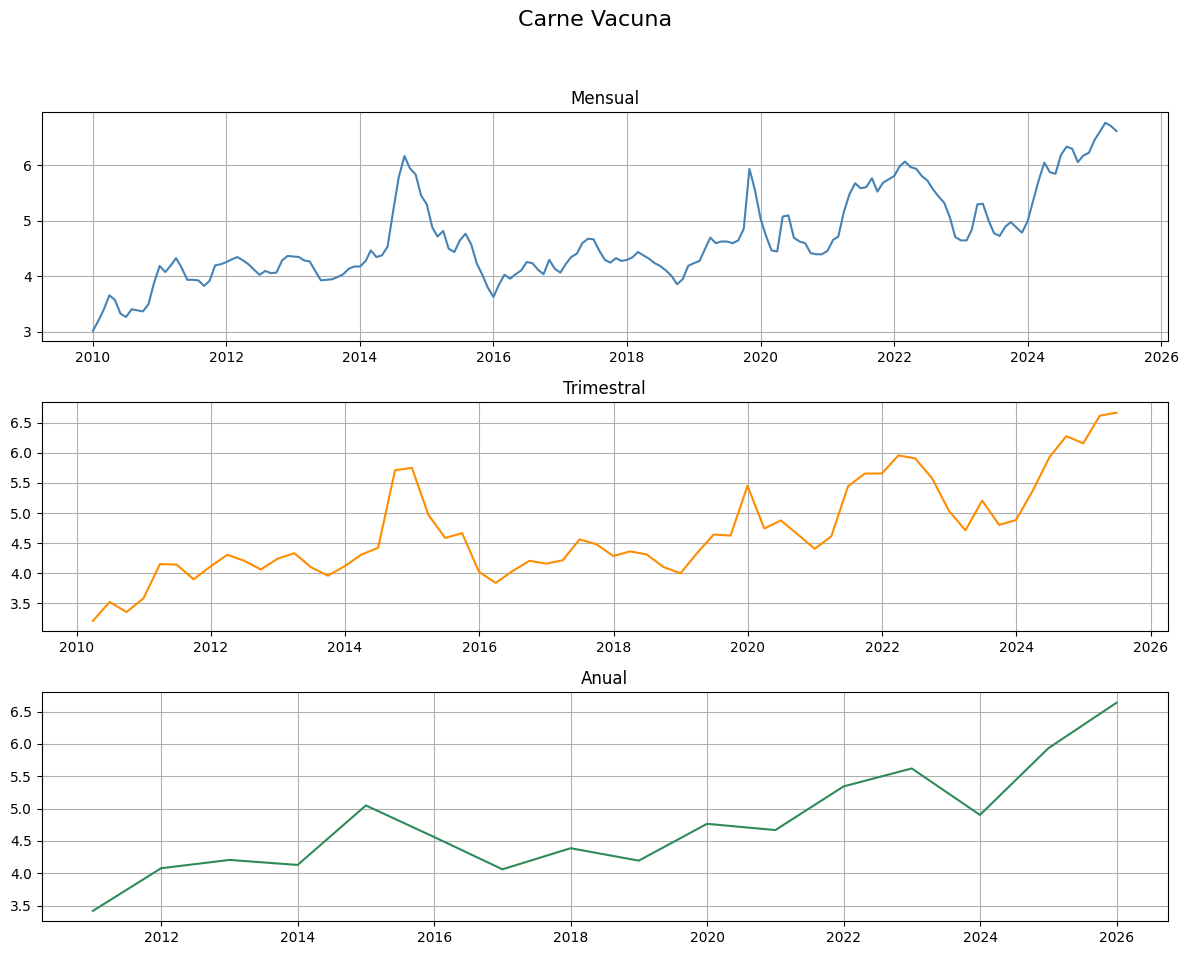

In [131]:
plot_time_series_resamples(df_carne, title='Carne Vacuna')

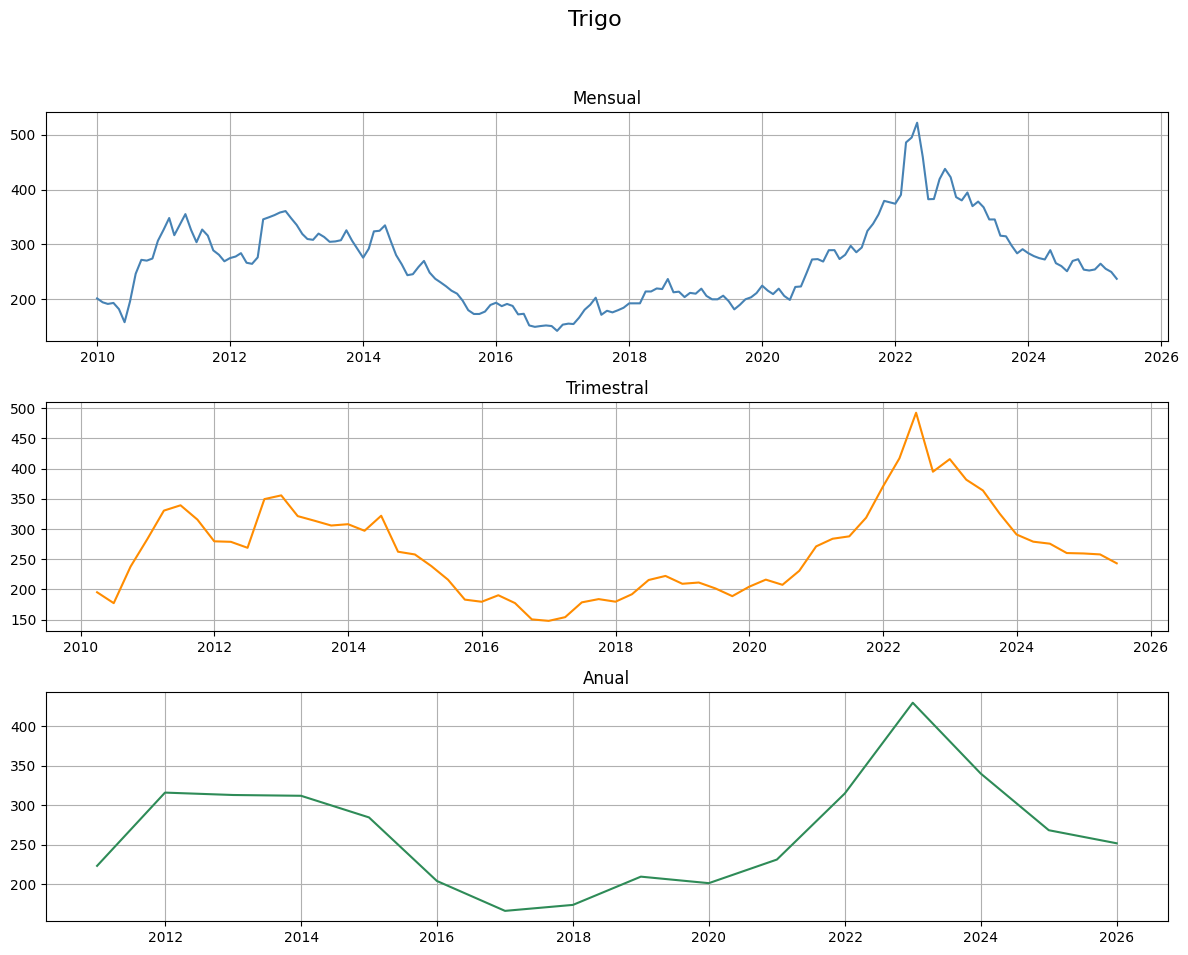

In [133]:
plot_time_series_resamples(df_trigo, title='Trigo')

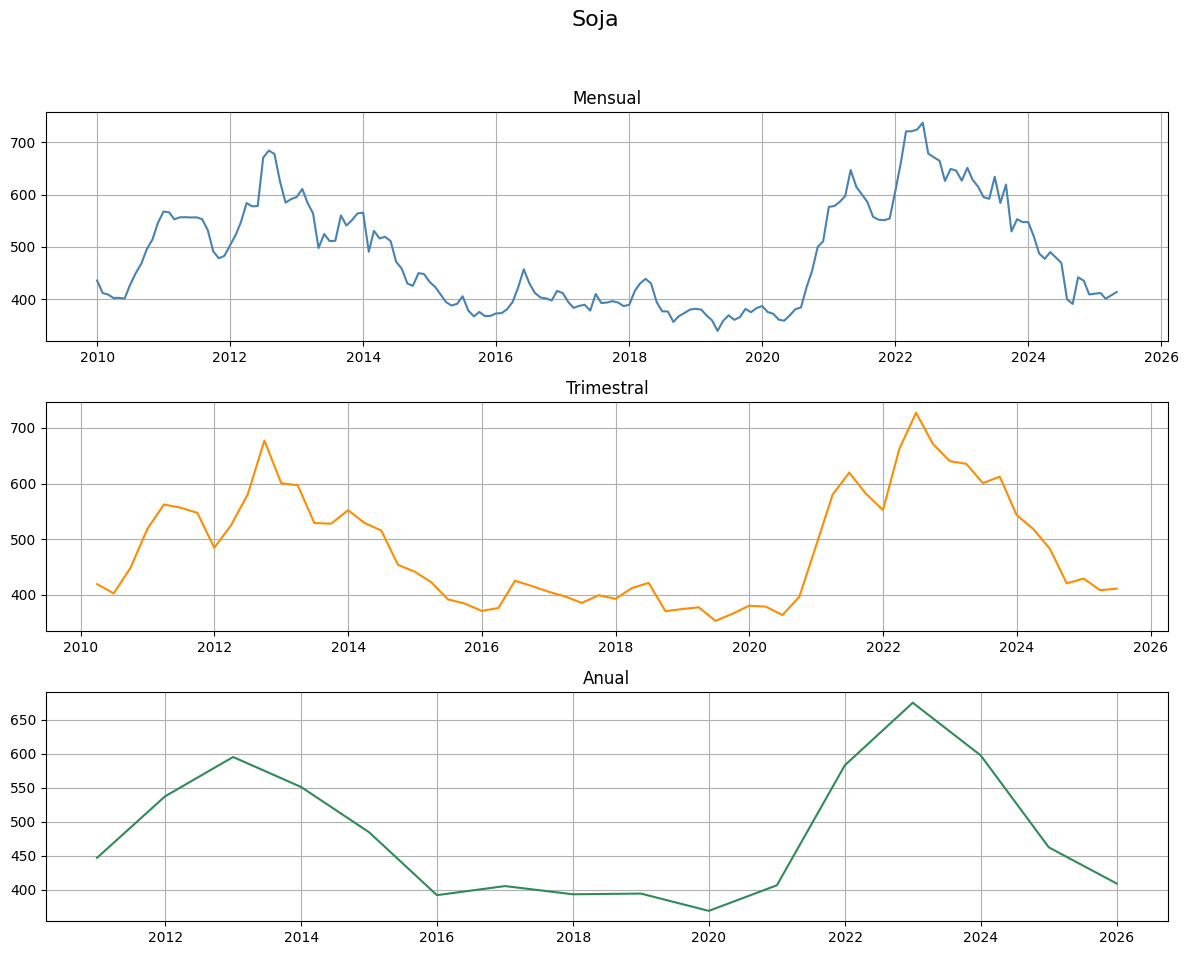

In [135]:
plot_time_series_resamples(df_soja, title='Soja')

## 3. Models and Evaluations

### 3.1 SARIMAX

### Time Series Modeling with SARIMAX

The **stationarity** and **seasonality** of each time series were thoroughly analyzed in the [`SARIMAX.ipynb`](notebooks/SARIMAX.ipynb) notebook. This involved visual inspection as well as statistical methods, including ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots, both **before and after differencing** the series. These tools were essential to determine the appropriate values for the SARIMAX model parameters: `p`, `d`, `q` for the non-seasonal component and `P`, `D`, `Q` for the seasonal part.

All models were trained using **exogenous variables**, as their absence significantly degraded the model's ability to capture the underlying trend of the target series. The exogenous variables included:

- Prices of **gold** and **other metals**
- **Energy market indicators**
- Prices of **other grains and commodities**

These variables were selected based on domain knowledge and correlation analysis, as they exhibit significant influence over the target variables.

To obtain robust parameter estimates, the **AutoARIMA** algorithm was also applied. This served as a complementary approach to manual inspection of ACF/PACF plots and allowed for an automatic exploration of a wide range of parameter combinations.

> **Important note**: In order to generate future forecasts using this model, future values of the exogenous variables must be available or estimated, as they are essential for producing accurate predictions.




In [23]:
from model_sarimax import ARIMAPipeline
import numpy as np
import joblib

MAE test: 0.62
RMSE test: 0.76
MAPE test: 12.13%
---
MAE train: 0.15
RMSE train: 0.21
MAPE train: 3.31%


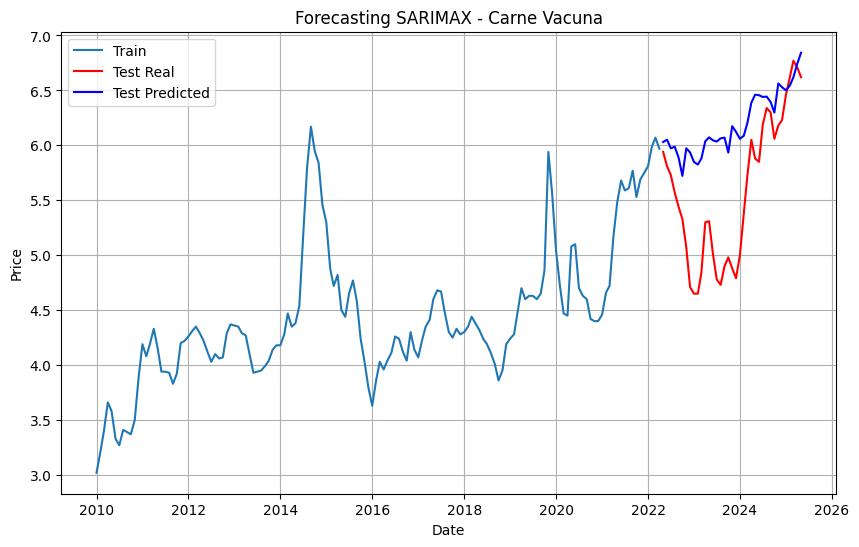

MAE test: 59.93
RMSE test: 80.52
MAPE test: 13.15%
---
MAE train: 71.06
RMSE train: 467.73
MAPE train: 13.59%


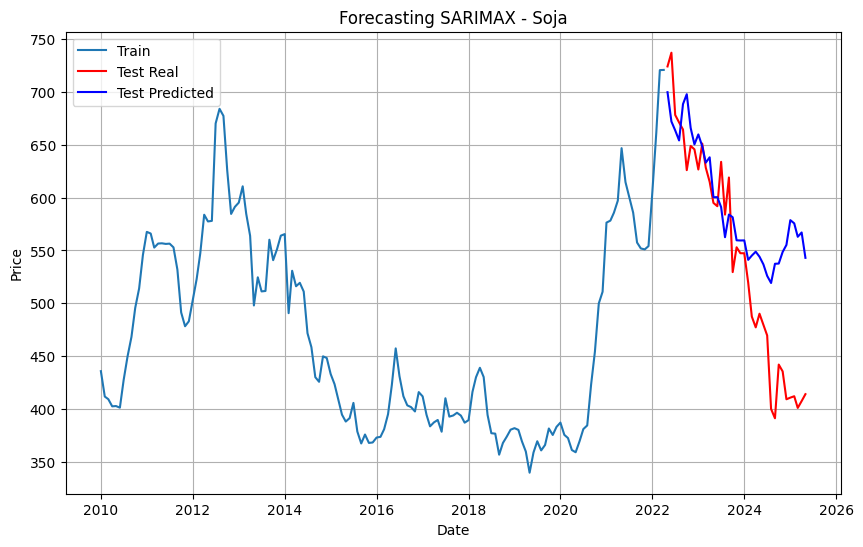

MAE test: 66.56
RMSE test: 74.84
MAPE test: 23.20%
---
MAE train: 14.32
RMSE train: 23.14
MAPE train: 5.59%


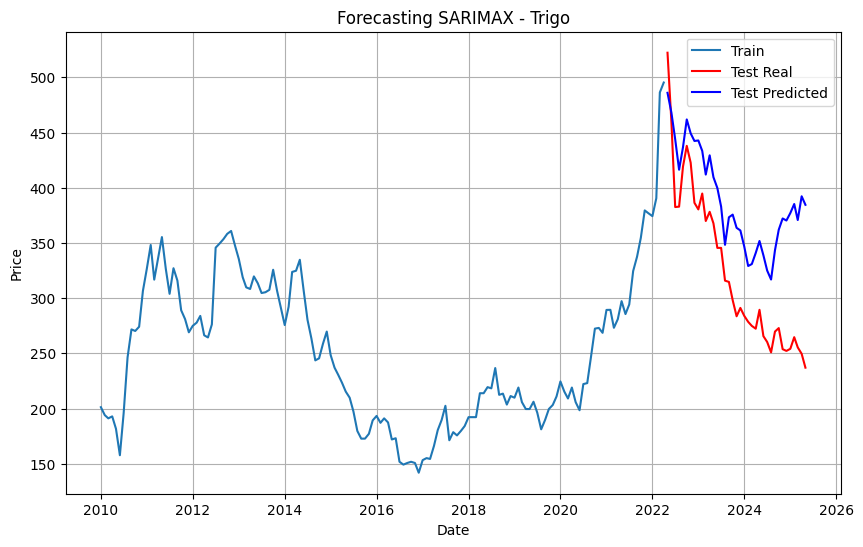

In [36]:
df = load_dataset()

commodity = ['Carne Vacuna', 'Soja', 'Trigo']
orders = [(0,1,1), (2,1,2), (1,1,1)]
seasonal_orders = [(0,1,1,12), (0,1,2,12), (1,1,1,12)]

exog_carne = pd.DataFrame(index=df.index)
exog_carne['log_energia'] = np.log(df['Energy'])
exog_carne['log_oro'] = np.log(df['Oro'])

exog_soja = pd.DataFrame(index=df.index)
exog_soja['log_maiz'] = np.log(df['Maiz'])
exog_soja['log_energia'] = np.log(df['Energy'])
exog_soja['log_trigo'] = np.log(df['Trigo'])
exog_soja['log_metal'] = np.log(df['Metal Index'])

exog_trigo = pd.DataFrame(index=df.index)
exog_trigo['log_maiz'] = np.log(df['Maiz'])
exog_trigo['log_energia'] = np.log(df['Energy'])
exog_trigo['log_soja'] = np.log(df['Soja'])
exog_trigo['log_metal'] = np.log(df['Metal Index'])

exogs = [exog_carne, exog_soja, exog_trigo]

for i, com in enumerate(commodity):
    train_size = int(len(df[com]) * 0.8)
    train = df[com].iloc[:train_size]
    test = df[com].iloc[train_size:]
    
    # Train
    pipe_arima = ARIMAPipeline(order=orders[i], seasonal_order=seasonal_orders[i])
    model = pipe_arima.fit(train, exogs[i].iloc[:train_size])

    # Save Model
    joblib.dump(model, f"{com.strip()}_model_sarimax_pipeline.pkl")

    # Predict
    pred_test = model.predict(test, exogs[i].iloc[train_size:])

    # Reports
    model.report()

    # Plots
    model.plot_predictions(title=f'Forecasting SARIMAX - {com}')


### 3.2 XGBoost


The [`XGBoost.ipynb`](notebooks/XGBoost.ipynb) notebook contains the exploratory analysis for modeling three time series: **Carne Vacuna**, **Trigo**, and **Soja** prices using the **XGBoost Regressor**.

It includes:
- Feature engineering (lags, seasonal differences, month dummies)
- Train/test splitting and time series cross-validation
- Hyperparameter tuning using GridSearchCV
- Model evaluation using RMSE, MAE, and MAPE
- Plots comparing true vs. predicted values


The best combination of hyperparameters was selected based on **negative mean squared error** (RMSE).

Each model was evaluated on the test set using the following metrics:

- **RMSE** (Root Mean Squared Error)
- **MAE** (Mean Absolute Error)
- **MAPE** (Mean Absolute Percentage Error)

Both training and test set predictions were generated for all three series, and visual comparisons were plotted to assess performance.

The models demonstrated strong ability to capture trends and seasonality, particularly when appropriate lag and seasonal features were included.

>  **Note**: Since the models rely on lag-based and calendar features, future forecasts depend on either known or estimated future values of these features. Recursive forecasting may be required for multi-step predictions.

In [5]:
import matplotlib.pyplot as plt
from model_xgboost import XGBoostPipeline
import joblib


In [4]:
def create_features(df, target_col, lags=[1], add_month_dummies=True):
    df_feat = pd.DataFrame(index=df.index)
    df_feat[target_col] = df[target_col]
    
    # Lags
    for lag in lags:
        df_feat[f'lag_{lag}'] = df[target_col].shift(lag)
    
    df_feat['lag_12']=df[target_col].shift(12)
    df_feat['diff_seas'] = df[target_col] - df[target_col].shift(12)
    df_feat['diff_price'] = df[target_col] - df[target_col].shift(1)
    
    # Estacionalidad 
    if add_month_dummies:
        df_feat['month'] = df.index.month
        df_feat = pd.get_dummies(df_feat, columns=['month'], drop_first=True)
        df_feat.astype(float)
    return df_feat.dropna()

Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAE_test: 0.28
RMSE_test: 0.38
MAPE_test: 4.47%
----
MAE_train: 0.04
RMSE_train: 0.06
MAPE_train: 0.88%


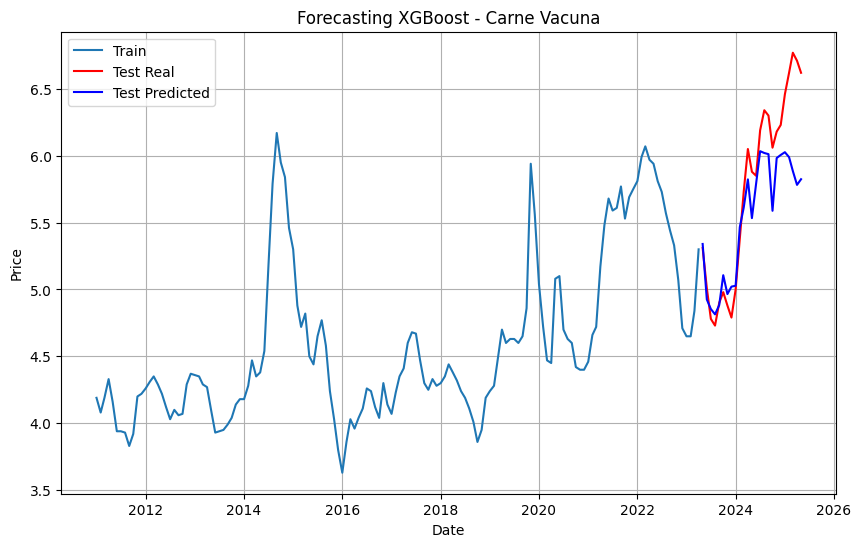

Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAE_test: 10.58
RMSE_test: 14.49
MAPE_test: 2.23%
----
MAE_train: 2.59
RMSE_train: 3.23
MAPE_train: 0.55%


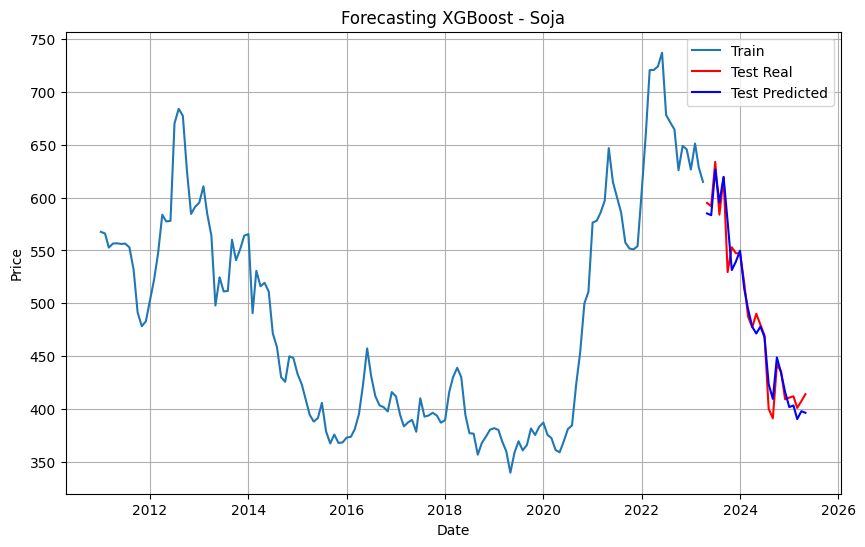

Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAE_test: 3.60
RMSE_test: 4.52
MAPE_test: 1.24%
----
MAE_train: 0.87
RMSE_train: 1.20
MAPE_train: 0.35%


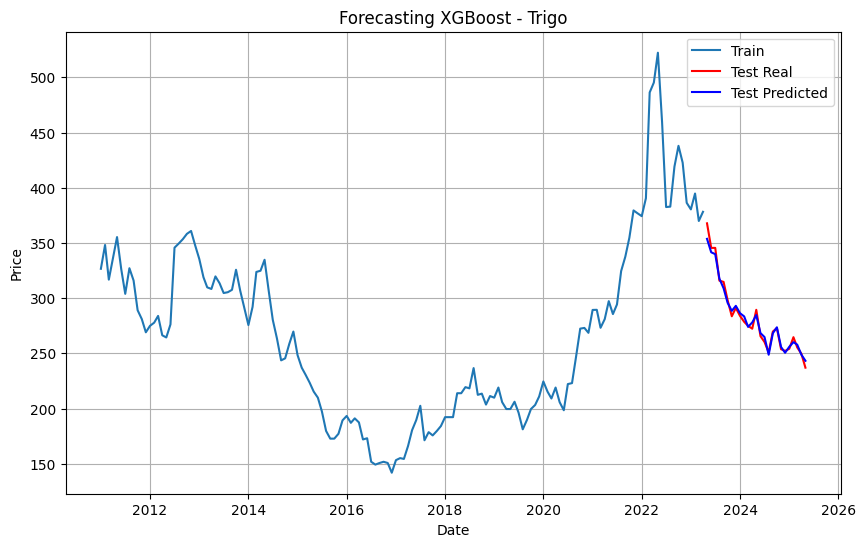

In [6]:
df = load_dataset()

train_size = int(len(df) * 0.8)
commodity = ['Carne Vacuna', 'Soja', 'Trigo']

for i, com in enumerate(commodity):
    df_feat = create_features(df, com, lags=[1])
    train = df_feat.iloc[:train_size]
    test = df_feat.iloc[train_size:]

    # Train
    pipe_XGB= XGBoostPipeline()
    model = pipe_XGB.fit(train, com)

    # Save Model
    joblib.dump(model, f"{com.strip()}_model_XGBoost_pipeline.pkl")

    # Predict
    pred_test = model.predict(test, com)

    # Reports
    model.report()

    # Plots
    model.plot_predictions(title=f'Forecasting XGBoost - {com}')


### 3.3 LSTM


The exploratory analysis and model design is developed in the [`LSTM.ipynb`](notebooks/LSTM.ipynb) notebook. That notebook includes:

- Feature engineering based on lagged values and seasonal differences
- Scaling of both input features and target variable using `MinMaxScaler`
- Definition and training of an LSTM architecture with dropout regularization
- Evaluation on a temporal train/test split using RMSE, MAE, and MAPE
- Visualization of predicted vs. actual values

The LSTM model is retrained using the optimal configuration, and predictions are generated for both training and testing periods. Evaluation metrics are logged, and plots are saved for visual inspection.

> **Note**: LSTM models are sensitive to the structure of input data. The training and prediction pipeline in `main.py` must replicate exactly the same preprocessing steps used during the exploratory phase — including lag creation and scaling — to ensure compatibility and reliable performance. Forecasting multiple future steps requires careful adaptation, such as recursive prediction or sequence-based input preparation.


In [11]:
import matplotlib.pyplot as plt
import joblib
from model_lstm import LSTMPipeline


In [3]:
def create_features(df, target_col, lags):
        df_feat = pd.DataFrame(index=df.index)
        df_feat[target_col] = df[target_col]
        for lag in lags:
            df_feat[f'lag_{lag}'] = df[target_col].shift(lag)
        df_feat['lag_12'] = df[target_col].shift(12)
        df_feat['diff_seas'] = df[target_col] - df[target_col].shift(12)
        df_feat['diff_price'] = df[target_col] - df[target_col].shift(1)
        df_feat = df_feat.dropna()
        return df_feat

5/5 [==============================] - 1s 3ms/step


INFO:tensorflow:Assets written to: models/Carne Vacuna_model_LSTM_pipeline\assets


INFO:tensorflow:Assets written to: models/Carne Vacuna_model_LSTM_pipeline\assets


1/1 [==============================] - 0s 26ms/step
MAE_test: 0.06
RMSE_test: 0.08
MAPE_test: 1.14%
----
MAE_train: 0.07
RMSE_train: 0.09
MAPE_train: 1.48%


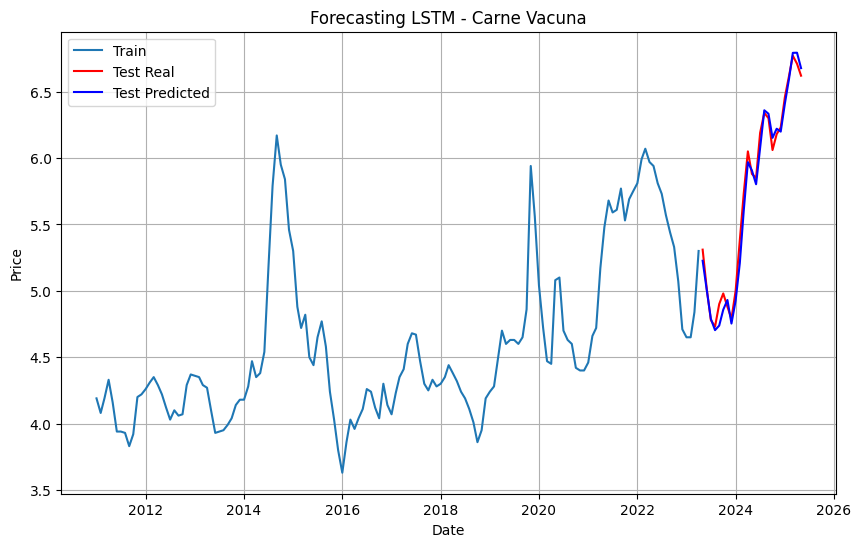

5/5 [==============================] - 1s 3ms/step


INFO:tensorflow:Assets written to: models/Soja_model_LSTM_pipeline\assets


INFO:tensorflow:Assets written to: models/Soja_model_LSTM_pipeline\assets


1/1 [==============================] - 0s 28ms/step
MAE_test: 9.35
RMSE_test: 12.04
MAPE_test: 1.91%
----
MAE_train: 8.21
RMSE_train: 10.61
MAPE_train: 1.78%


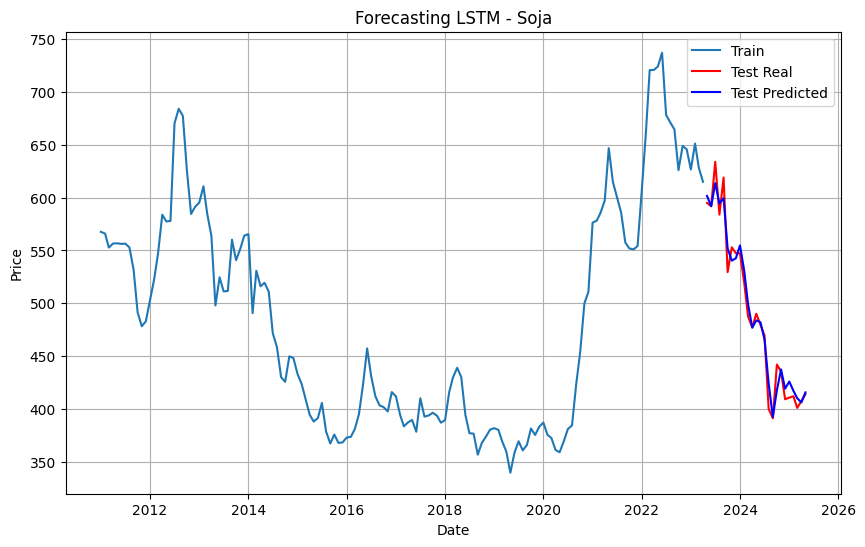

5/5 [==============================] - 1s 3ms/step


INFO:tensorflow:Assets written to: models/Trigo_model_LSTM_pipeline\assets


INFO:tensorflow:Assets written to: models/Trigo_model_LSTM_pipeline\assets


1/1 [==============================] - 0s 26ms/step
MAE_test: 7.42
RMSE_test: 8.76
MAPE_test: 2.60%
----
MAE_train: 7.55
RMSE_train: 10.12
MAPE_train: 2.83%


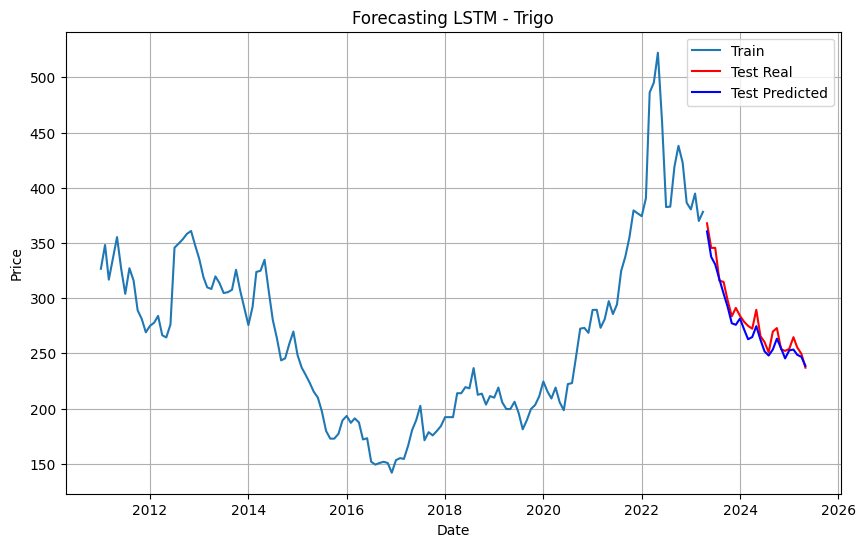

In [14]:
df = load_dataset()

train_size = int(len(df) * 0.8)
commodity = ['Carne Vacuna', 'Soja', 'Trigo']

for i, com in enumerate(commodity):
    df_feat = create_features(df, com, lags=[1])
    train = df_feat.iloc[:train_size]
    test = df_feat.iloc[train_size:]
    
    # Train
    pipe_LSTM = LSTMPipeline()
    model = pipe_LSTM.fit(train, com)

    # Save Model
    pipe_LSTM.model.save("models/"+ f"{com.strip()}_model_LSTM_pipeline")
    

    # Predict
    pred_test = model.predict(test, com)

    # Reports
    model.report()

    # Plots
    model.plot_predictions(title=f'Forecasting LSTM - {com}')


## 4. Final Model Comparison and Winner Selection

In [39]:
results_df = pd.DataFrame([
    {'Commodity': 'Carne Vacuna', 'Modelo': 'SARIMAX', 'RMSE': 0.75, 'MAE': 0.62, 'MAPE': 12.12},
    {'Commodity': 'Carne Vacuna', 'Modelo': 'XGBoost', 'RMSE': 0.28, 'MAE': 0.38, 'MAPE': 4.47},
    {'Commodity': 'Carne Vacuna', 'Modelo': 'LSTM', 'RMSE': 0.06, 'MAE': 0.08, 'MAPE': 1.14},
    {'Commodity': 'Trigo', 'Modelo': 'SARIMAX', 'RMSE': 74.84, 'MAE': 66.56, 'MAPE': 23.20},
    {'Commodity': 'Trigo', 'Modelo': 'XGBoost', 'RMSE': 4.52, 'MAE': 3.60, 'MAPE': 1.24},
    {'Commodity': 'Trigo', 'Modelo': 'LSTM', 'RMSE': 8.6, 'MAE': 7.42, 'MAPE': 2.60},
    {'Commodity': 'Soja', 'Modelo': 'SARIMAX', 'RMSE': 80.52, 'MAE': 59.93, 'MAPE': 13.15},
    {'Commodity': 'Soja', 'Modelo': 'XGBoost', 'RMSE': 14.49, 'MAE': 14.49, 'MAPE': 2.23},
    {'Commodity': 'Soja', 'Modelo': 'LSTM', 'RMSE': 12.04, 'MAE': 9.35, 'MAPE': 1.91},
])



In [62]:
import plotly.express as px

def plot_model_comparison_interactive(results_df, metric='RMSE'):
    fig = px.bar(
        results_df,
        x="Commodity",
        y=metric,
        color="Modelo",
        barmode="group",
        text_auto=True,
        title=f"Model comparison by series using {metric}",
        template='plotly_white'
    )
    fig.update_layout(
        title_font_size=18,
        legend_title='Model',
        xaxis_title="Serie",
        yaxis_title=metric
    )
    fig.write_image('model_comparison.png')
    fig.show()
    

In [63]:
plot_model_comparison_interactive(results_df, metric='MAPE')


## 5. Final Conclusion

This analysis explored three distinct modeling approaches — SARIMAX, XGBoost, and LSTM — to forecast the monthly prices of three key agricultural commodities: **Carne Vacuna**, **Trigo**, and **Soja**.

Each model was developed and evaluated based on:

- Feature relevance and preprocessing needs
- Capacity to capture trend and seasonality
- Forecasting accuracy using RMSE, MAE, and MAPE

**SARIMAX** leveraged time series decomposition and exogenous variables to model underlying trends and seasonal patterns.  
**XGBoost** combined manually engineered lag features with tree-based learning, offering flexibility and robustness.  
**LSTM**, a recurrent neural network model, was trained on normalized sequences to capture complex temporal dependencies.

After comparing the performance of all models across the three series, the final results suggest that:

- **XGBoost consistently achieved strong predictive accuracy** while maintaining lower complexity and training time.
- **SARIMAX performed well**, particularly when exogenous variables were present and well-correlated.
- **LSTM models showed potential**, but were more sensitive to data scaling and required careful tuning to avoid overfitting.

> **Final selection**: XGBoost was chosen as the best-performing model overall, balancing accuracy, interpretability, and reproducibility.

This modeling pipeline provides a solid foundation for future extensions such as multistep forecasting, inclusion of external economic indicators, or deployment in real-time prediction environments.


## 6. Forecast using the best model

### 6.1 Train the model with all historic data

In [2]:
historic = load_dataset()

In [55]:
import model_xgboost
importlib.reload(model_xgboost)
from model_xgboost import XGBoostPipeline
import joblib

commodity = ['Carne Vacuna', 'Trigo', 'Soja']

for i, com in enumerate(commodity):
    df_feat = create_features(historic, com, lags=[1])
    pipe_XGB= XGBoostPipeline()
    model = pipe_XGB.fit(df_feat, com)
    # Save Final Model
    joblib.dump(model, f"{com.strip()}_final_model_pipeline.pkl")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


### 6.2 Predict new values (next 12 months)

In [63]:
from predict import forecasting_recursive

path_output = './output/'

model_carne_vacuna = joblib.load('./models/Carne Vacuna_final_model_pipeline.pkl')
model_trigo = joblib.load('./models/Trigo_final_model_pipeline.pkl')
model_soja = joblib.load('./models/Soja_final_model_pipeline.pkl')

forecast_carne = forecasting_recursive(model_carne_vacuna, historic, 'Carne Vacuna', steps_ahead=12, output_csv=path_output +'forecast_carne.csv')
forecast_trigo = forecasting_recursive(model_trigo, historic, 'Trigo', steps_ahead=12, output_csv=path_output +'forecast_trigo.csv')
forecast_soja = forecasting_recursive(model_soja, historic, 'Soja', steps_ahead=12, output_csv=path_output +'forecast_soja.csv')


Forecast saved to ./output/forecast_carne.csv
Forecast saved to ./output/forecast_trigo.csv
Forecast saved to ./output/forecast_soja.csv


### 6.3 Forecasting plots

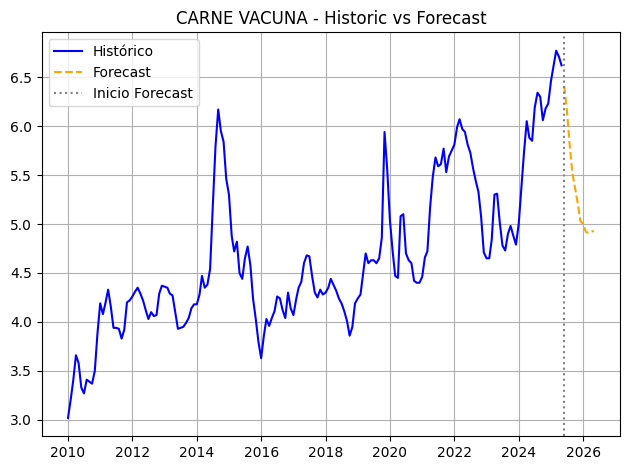

In [64]:
predict.plot_forecasts_with_history(forecast_carne, 'Carne Vacuna', forecast_horizon=12)


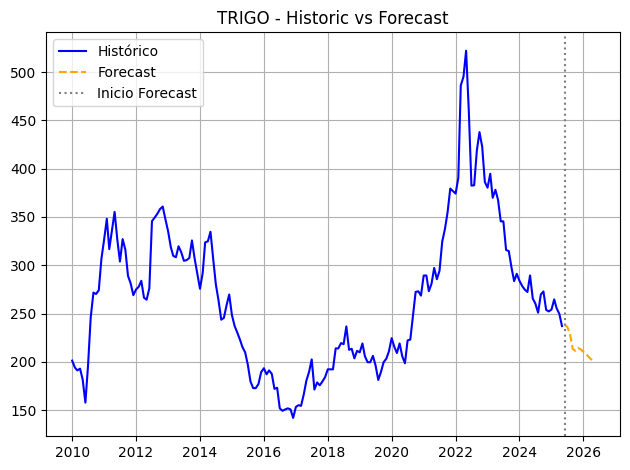

In [65]:
predict.plot_forecasts_with_history(forecast_trigo, 'Trigo', forecast_horizon=12)

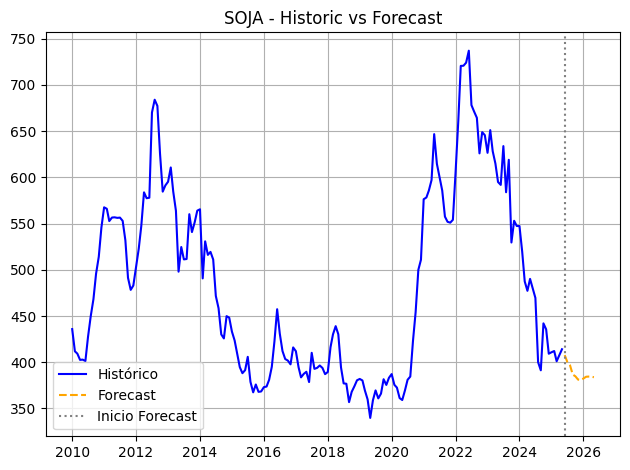

In [66]:
predict.plot_forecasts_with_history(forecast_soja, 'Soja', forecast_horizon=12)